In [1]:
import hyperopt

In [4]:
import seaborn as sns
import numpy as np
import pandas as pd

In [7]:
import pandas_ta as ta

In [8]:
x = np.arange(-10,11)

In [9]:
x

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

In [11]:
y = -(x**2)+40

In [12]:
y

array([-60, -41, -24,  -9,   4,  15,  24,  31,  36,  39,  40,  39,  36,
        31,  24,  15,   4,  -9, -24, -41, -60])

/Users/nielshoogeveen/Desktop/Projects/auto_autoML/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

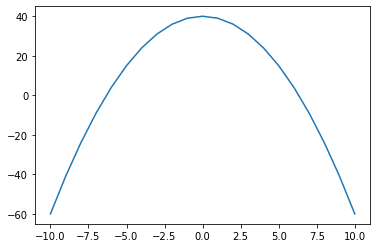

In [13]:
sns.lineplot(x,y)

In [14]:
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=lambda x: -1*(-(x**2)+40),
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [00:00<00:00, 426.45trial/s, best loss: -39.999440622585496]


In [15]:
best

{'x': -0.023651160954702266}

-----

In [16]:
import optuna

In [17]:
df = pd.read_csv('BTC-USD.csv')

In [18]:
df = df.loc[lambda d: ~d['Close'].isna()]

In [19]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
...,...,...,...,...,...,...,...
2313,2021-01-16,36821.648438,37864.367188,35633.554688,36178.140625,36178.140625,5.770619e+10
2314,2021-01-17,36163.648438,36722.351563,34069.320313,35791.277344,35791.277344,5.235985e+10
2315,2021-01-18,35792.238281,37299.285156,34883.843750,36630.074219,36630.074219,4.951170e+10
2316,2021-01-19,36642.234375,37755.890625,36069.804688,36069.804688,36069.804688,5.724420e+10


In [20]:
def get_macd(df, fast=8, slow=16, signal=6):
    df_temp = ta.macd(df['Close'], fast=fast, slow=slow, signal=signal)

    return df.merge(df_temp, left_index=True, right_index=True)

In [21]:
def signal_MACD(df, fast=8, slow=16, signal=6):
    conditions = [
        ((df[f'MACDh_{fast}_{slow}_{signal}'].shift(1) <= 0) & (df[f'MACDh_{fast}_{slow}_{signal}'] > 0)),
        ((df[f'MACDh_{fast}_{slow}_{signal}'].shift(1) >= 0) & (df[f'MACDh_{fast}_{slow}_{signal}'] < 0)),
    ]

    choices = ['Buy', 'Sell']

    df['signal_MACD'] = np.select(conditions, choices, default='Nothing')

    return df

In [22]:
df_trades = pd.DataFrame({
    'Date': [],
    'Buying_price': [],
    'Selling_price': [],
    'Profit': []
})

In [23]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [28]:
def simulate(df):
    
    for days in range(days_to_simulate):
    
        df_trades=pd.DataFrame({
        'Date': [],
        'Buying_price': [],
        'Selling_price': [],
        'Profit': []
        })

        if df.iloc[-1]['signal_MACD']=='Buy':
            date = df.iloc[-1]['signal_MACD']['Date']
            buying_price = df.iloc[-1]['signal_MACD']['Close']

            df_trades_temp = pd.DataFrame({
                'Date': [date],
                'Buying_price': [buying_price],
                'Trade': ['BUY'],
                'Selling_price': [0],
                'Profit': [0]
            })

            df_trades = pd.concat([df_trades, df_trades_temp])


        elif df.iloc[-1]['signal_MACD']=='Sell' and len(df_trades)>0:
            date = df_trades.loc[lambda d: d['Trade'] == 'BUY'].iloc[-1]['Date']
            buying_price = df.loc[lambda d: d['Trade'] == 'BUY'].iloc[-1]['Buying_price']
            current_price = df.tail(1)['Close'].values[0]
            
            
            df_trades_temp = pd.DataFrame({
                'Date': [date],
                'Buying_price': [buying_price],
                'Trade': ['SELL'],
                'Selling_price': [current_price],
                'Profit': [0]
            })

        
        

In [29]:
df = get_macd(df).pipe(signal_MACD)

In [32]:
df[df['signal_MACD']!='Nothing']

,Date,Open,High,Low,Close,Adj Close,Volume,MACD_8_16_6,MACDh_8_16_6,MACDs_8_16_6,signal_MACD
21,2014-10-08,336.115997,354.364014,327.187988,352.940002,352.940002,5.473630e+07,-19.223578,0.564753,-19.788331,Buy
36,2014-10-23,382.962006,385.048004,356.446991,358.416992,358.416992,2.645690e+07,-0.582172,-2.009568,1.427396,Sell
49,2014-11-05,330.683014,343.368988,330.683014,339.485992,339.485992,1.981720e+07,-9.000106,0.617057,-9.617163,Buy
62,2014-11-18,387.785004,392.402008,371.117004,375.197998,375.197998,3.222250e+07,7.405957,-1.262933,8.668890,Sell
72,2014-11-28,369.373993,382.838013,358.454987,376.446991,376.446991,2.294650e+07,0.618385,0.176818,0.441567,Buy
...,...,...,...,...,...,...,...,...,...,...,...
2261,2020-11-25,19104.410156,19390.964844,18581.146484,18732.121094,18732.121094,4.371036e+10,844.923197,-15.982769,860.905966,Sell
2268,2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,19201.091797,3.738770e+10,537.040839,5.014437,532.026402,Buy
2270,2020-12-04,19446.966797,19511.404297,18697.193359,18699.765625,18699.765625,3.387239e+10,491.702415,-35.564198,527.266613,Sell
2281,2020-12-15,19246.919922,19525.007813,19079.841797,19417.076172,19417.076172,2.674198e+10,223.493965,24.484214,199.009751,Buy


In [ ]:
def objective(trial):
    MACD_fast = trial.suggest_uniform('a', -10.0, 10.0)
#     b = trial.suggest_uniform('b', -10.0, 10.0)
#     c = trial.suggest_uniform('c', -10.0, 10.0)
    
    profit = 0  
    
    if (a>7) and (a<9):
        profit = profit + 3
    elif (a > 5) and (a<10):
        profit = profit + 1
        
    elif (a>2) and (a<5):
        profit = profit + 5
    else:
        profit = 0
        
    return profit

<AxesSubplot:xlabel='Date', ylabel='Close'>

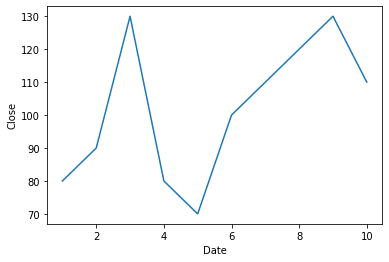

In [70]:
sns.lineplot(df['Date'], df['Close'])

In [39]:
def run(params):
    a = params['a']
    
    profit = 0  
    
    if (a>7) and (a<9):
        profit = profit + 3
    elif (a > 5) and (a<10):
        profit = profit + 1
        
    elif (a>2) and (a<5):
        profit = profit + 5
    else:
        profit = 0
        
    return profit

In [34]:
def objective(trial):
    a = trial.suggest_uniform('a', -10.0, 10.0)
#     b = trial.suggest_uniform('b', -10.0, 10.0)
#     c = trial.suggest_uniform('c', -10.0, 10.0)
    
    profit = 0  
    
    if (a>7) and (a<9):
        profit = profit + 3
    elif (a > 5) and (a<10):
        profit = profit + 1
        
    elif (a>2) and (a<5):
        profit = profit + 5
    else:
        profit = 0
        
    return profit

In [35]:
study = optuna.create_study(direction='maximize')

[I 2021-04-27 13:17:45,720] A new study created in memory with name: no-name-07350f58-c426-4506-be0b-0feeb0e94b28


In [36]:
study.optimize(objective, n_trials=500)

[I 2021-04-27 13:17:46,165] Trial 0 finished with value: 0.0 and parameters: {'a': -6.0416557440336565}. Best is trial 0 with value: 0.0.
[I 2021-04-27 13:17:46,166] Trial 1 finished with value: 5.0 and parameters: {'a': 4.753228928684743}. Best is trial 1 with value: 5.0.
[I 2021-04-27 13:17:46,167] Trial 2 finished with value: 0.0 and parameters: {'a': -3.0124214272122396}. Best is trial 1 with value: 5.0.
[I 2021-04-27 13:17:46,168] Trial 3 finished with value: 0.0 and parameters: {'a': -4.599211755890192}. Best is trial 1 with value: 5.0.
[I 2021-04-27 13:17:46,169] Trial 4 finished with value: 5.0 and parameters: {'a': 4.926507994815061}. Best is trial 1 with value: 5.0.
[I 2021-04-27 13:17:46,171] Trial 5 finished with value: 0.0 and parameters: {'a': -3.209099970121569}. Best is trial 1 with value: 5.0.
[I 2021-04-27 13:17:46,171] Trial 6 finished with value: 1.0 and parameters: {'a': 6.304343236300646}. Best is trial 1 with value: 5.0.
[I 2021-04-27 13:17:46,173] Trial 7 finish

In [37]:
study.best_params

{'a': 4.753228928684743}

In [40]:
run(study.best_params)

5